Multiplicative update rules for NMF 
----
NMF: $\boldsymbol{X} \approx \boldsymbol{WH}$, where $\boldsymbol{X} \in \mathbb{R}_+^{m \times n}$, $\boldsymbol{W} \in \mathbb{R}_+^{m \times r}$, and $\boldsymbol{H} \in \mathbb{R}_+^{r \times n}$.

Error functions:

- Euclidean distance
- I-divergence
- Dual I-divergence
- Itakura-Saito divergence
- $\alpha$-divergence
- $\beta$-divergence

Notations: 

- $\odot$ -- Hadamard product 
- $\oslash$ -- Hadamard division 
- $A^{\circ n}$ -- Given a matrix $A$, $A^{\circ n}$means the Hadamard power of A.
- $\boldsymbol{1}$ -- $m \times n$ matrix whose elements are all equal to 1.
- $\exp(A)$ -- Given a matrix A, $\exp(A)$ means that the (i, j) element is $\exp(A_{ij})$.
- $\ln(A)$ -- Given a matrix A, $\ln(A)$ means that the (i, j) element is $\ln(A_{ij})$.


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# machine epsilon setting
eps = sys.float_info.epsilon

Multiplicative update rules with Euclidean distance
----

Error function:

$$
D_{EU}(X||WH) = \sum_{ij} (X_{ij} - (WH)_{ij})^2
$$

Algorithm:
$$
W^\mathrm{new} \gets W \odot XH^T \oslash WHH^T
$$

$$
H^\mathrm{new} \gets H \odot (W^\mathrm{new})^TX \oslash (W^\mathrm{new})^TW^\mathrm{new}H
$$

In [3]:
def EuclideanDistance(X, W, H):
    return np.sum((X - np.dot(W, H))**2)

def MurEuclideanDistance(X, W, H):
    
    # update W
    W_new = W * np.dot(X, H.T) / np.dot(W, np.dot(H, H.T))
    W_new = np.where(W_new < eps, eps, W_new)
    
    # update H
    H_new = H * np.dot(W_new.T, X) / np.dot(W_new.T, np.dot(W_new, H))
    H_new = np.where(H_new < eps, eps, H_new)
    
    return W_new, H_new

Multiplicative update rules with I-divergence
----

Error function:

$$
D_I(X||WH) = \sum_{ij} \left( X_{ij} \ln \frac{X_{ij}}{(WH)_{ij}} - X_{ij} + (WH)_{ij} \right)
$$

Algorithm:

$$
Z_W \gets X \oslash WH
$$

$$
W^\mathrm{new} \gets W \odot Z_WH^T \oslash \boldsymbol{1}H^T
$$

$$
Z_H \gets X \oslash W^\mathrm{new}H
$$

$$
H^\mathrm{new} \gets H \odot (W^\mathrm{new})^TZ_H \oslash (W^\mathrm{new})^T\boldsymbol{1}
$$

In [4]:
def IDivergence(X, W, H):
    WH = np.dot(W, H)
    return np.sum(X * np.log((X + eps) / WH) - X + WH)

def MurIDivergence(X, W, H):
    one = np.ones_like(X)
    
    # update W
    Z_W = X / np.dot(W, H)
    W_new = W * np.dot(Z_W, H.T) / np.dot(one, H.T)
    W_new = np.where(W_new < sys.float_info.epsilon, sys.float_info.epsilon, W_new)
    
    # update H
    Z_H = X / np.dot(W_new, H)
    H_new = H * np.dot(W_new.T, Z_H) / np.dot(W_new.T, one)
    H_new = np.where(H_new < sys.float_info.epsilon, sys.float_info.epsilon, H_new)
    
    return W_new, H_new

Multiplicative update rules with dual I-divergence
----

Error function:

$$
D_I(WH||X) = \sum_{ij} \left( (WH)_{ij} \ln \frac{(WH)_{ij}}{X_{ij}} - (WH)_{ij} + X_{ij} \right)
$$

Algorithm:

$$
Z_W \gets X \oslash WH
$$

$$
W^\mathrm{new} \gets W \odot \exp \left( (\ln Z_W)H^T \oslash \boldsymbol{1}H^T \right)
$$

$$
Z_H \gets X \oslash W^\mathrm{new}H
$$

$$
H^\mathrm{new} \gets H \odot \exp \left( (W^\mathrm{new})^T(\ln Z_H) \oslash (W^\mathrm{new})^T \boldsymbol{1} \right)
$$


In [5]:
def DIDivergence(X, W, H):
    WH = np.dot(W, H)
    return np.sum(WH * np.log(WH / (X + eps)) - WH + X)

def MurDIDivergence(X, W, H):
    one = np.ones_like(X)
    
    # update W
    Z_W = (X + eps) / np.dot(W, H)
    Z_W = np.where(Z_W < sys.float_info.epsilon, sys.float_info.epsilon, Z_W)
    W_new = W * np.exp(np.dot(np.log(Z_W), H.T) / np.dot(one, H.T))
    W_new = np.where(W_new < eps, eps, W_new)
    
    # update H
    Z_H = (X + eps) / np.dot(W_new, H)
    Z_H = np.where(Z_H < sys.float_info.epsilon, sys.float_info.epsilon, Z_H)
    H_new = H * np.exp(np.dot(W_new.T, np.log(Z_H)) / np.dot(W_new.T, one))
    H_new = np.where(H_new < eps, eps, H_new)
    
    return W_new, H_new

Multiplicative update rules with Itakura-Saito divergence
----

Error function:

$$
D_{IS}(X||WH) = \sum_{ij} \left( -\ln \left(\frac{X_{ij}}{(WH)_{ij}} \right) + \frac{X_{ij}}{(WH)_{ij}} -1 \right)
$$

Algorithm:

$$
W^\mathrm{new} \gets W \odot \sqrt{
((X \oslash (WH)^{\circ 2})H^T) \oslash
((\boldsymbol{1} \oslash WH)H^T)
}
$$

$$
H^\mathrm{new} \gets H \odot \sqrt{
((W^\mathrm{new})^T(X \oslash (W^\mathrm{new}H)^{\circ 2})) \oslash
((W^\mathrm{new})^T (\boldsymbol{1} \oslash W^\mathrm{new} H))
}
$$


In [6]:
def ItakuraSaitoDivergence(X, W, H):
    WH = np.dot(W, H)
    one = np.ones_like(X)
    return np.sum(-np.log((X / WH) + eps) + X / WH - one)

def MurItakuraSaitoDivergence(X, W, H):
    one = np.ones_like(X)
    
    # update W
    W_new = W * np.sqrt((np.dot(X / np.dot(W, H)**2, H.T)) / (np.dot(one / np.dot(W, H), H.T)))
    W_new = np.where(W_new < eps, eps, W_new)
    
    # update H
    H_new = H * np.sqrt((np.dot(W_new.T, X / np.dot(W_new, H)**2))  / (np.dot(W_new.T, one / np.dot(W_new, H))))
    H_new = np.where(H_new < eps, eps, H_new)
    
    return W_new, H_new

Multiplicative update rules with $\alpha$-divergence
----

Error function:

$$
D_\alpha(X||WH) = \frac{1}{\alpha(1-\alpha)} \sum_{ij} \left( \alpha X_{ij} + 
(1-\alpha)(WH)_{ij} - X_{ij}^\alpha (WH)_{ij}^{1-\alpha} \right)
$$

Algorithm:

$$
Z_W \gets X \oslash WH
$$

$$
W^\mathrm{new} \gets W \odot (Z_W^{\circ \alpha} H^T \oslash \boldsymbol{1}H^T )^{\circ 1/\alpha}
$$

$$
Z_H \gets X \oslash W^\mathrm{new}H
$$

$$
H^\mathrm{new} \gets H \odot ((W^\mathrm{new})^T(Z_H^{\circ \alpha}) \oslash (W^\mathrm{new})^T\boldsymbol{1})^{\circ 1/\alpha}
$$


In [7]:
def AlphaDivergence(X, W, H, alpha):
    WH = np.dot(W, H)
    return np.sum(alpha * X + (1-alpha) * WH - X**alpha * WH**(1-alpha)) / (alpha * (1-alpha))

def MurAlphaDivergence(X, W, H, alpha):
    one = np.ones_like(X)
    
    # update W
    Z_W = X / np.dot(W, H)
    W_new = W * (np.dot(Z_W**alpha, H.T) / np.dot(one, H.T))**(1/alpha)
    W_new = np.where(W_new < eps, eps, W_new)
    
    # update H
    Z_H = X / np.dot(W_new, H)
    H_new = H * (np.dot(W_new.T, Z_H**alpha) / np.dot(W_new.T, one))**(1/alpha) 
    H_new = np.where(H_new < eps, eps, H_new)
    
    return W_new, H_new

Multiplicative update rules with $\beta$-divergence
----

Error function:

$$
D_\beta(X||WH) = \sum_{ij} \left( X_{ij}\frac{X_{ij}^\beta - (WH)_{ij}^\beta}{\beta} - 
\frac{X_{ij}^{\beta+1} - (WH)_{ij}^{\beta+1}}{\beta+1} \right)
$$

Algorithm:

$$
\eta \gets 
\begin{cases}
1/\beta \quad\quad\quad\  \mbox{for } \beta > 1 \\
1 \quad\quad\quad\ \ \ \  \mbox{for } 0 < \beta < 1 \\
1/(1-\beta) \quad\  \mbox{for } \beta < 0
\end{cases}
$$

$$
W^\mathrm{new} \gets W \odot 
\left[((X \oslash (WH)^{\circ \beta-1})H^T) \oslash
((WH)^{\circ \beta} H^T) \right]^{\circ \eta}
$$

$$
H^\mathrm{new} \gets H \odot 
\left[ ((W^\mathrm{new})^T(X \oslash (W^\mathrm{new}H)^{\circ \beta-1})) \oslash
((W^\mathrm{new})^T (W^\mathrm{new} H)^{\circ \beta}) \right]^{\circ \eta}
$$

In [8]:
def BetaDivergence(X, W, H, beta):
    WH = np.dot(W, H)
    return np.sum(X * (X**beta - WH**beta) / beta - (X**(beta+1) - WH**(beta+1)) / (beta+1))

def MurBetaDivergence(X, W, H, beta):
    if beta > 1:
        eta = 1.0 / beta
    elif 0 < beta < 1:
        eta = 1.0
    else:
        eta = 1.0 / (1 - beta)
    
    # update W
    WH = np.dot(W, H)
    W_new = W * ((np.dot(X / WH**(beta-1), H.T)) / (np.dot(WH**beta, H.T)))**eta
    W_new = np.where(W_new < eps, eps, W_new)
    
    # update H
    WH = np.dot(W_new, H)
    H_new = H * ((np.dot(W_new.T, X / WH**(beta-1))) / (np.dot(W_new.T, WH**beta)))**eta
    H_new = np.where(H_new < eps, eps, H_new)
    
    return W_new, H_new

Numerical Experiments
----

### Preparation

In [9]:
# olivetti faces dataset used
from sklearn import datasets

# given matrix X
X = datasets.fetch_olivetti_faces().data.T
m, n = X.shape

In [10]:
# seed setting
np.random.seed(0)

In [11]:
# max iteration
max_iter = 300

In [12]:
# nonnegative basis number
r = 5

### Convergence Analysis

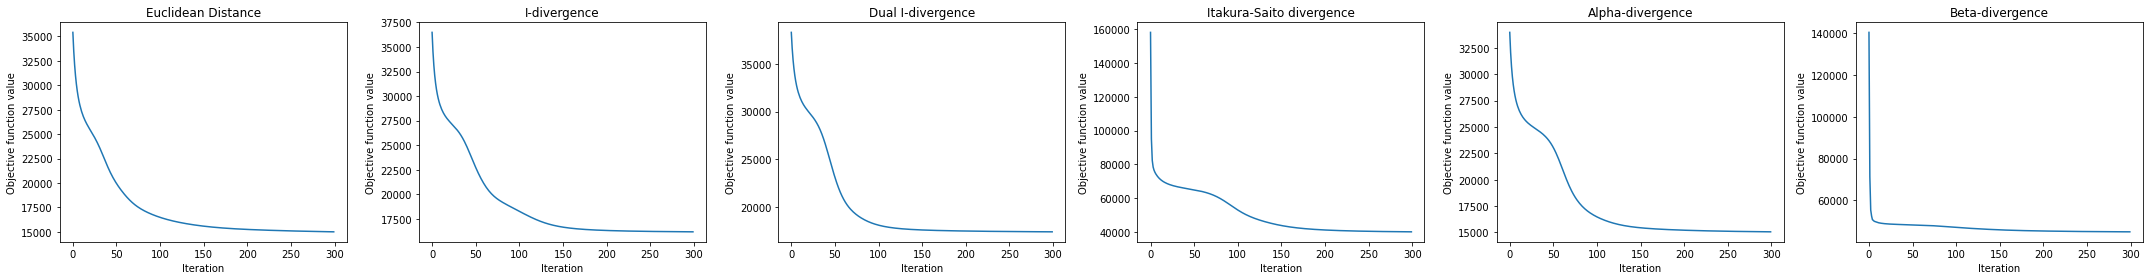

In [13]:
# Error function values
err_val = []
err_func_name = ['Euclidean Distance', 'I-divergence', 'Dual I-divergence', 
                 'Itakura-Saito divergence', 'Alpha-divergence', 'Beta-divergence']

# Euclidean distance 
EU_val = []
W = np.random.uniform(low = eps, high = 1.0, size = (m, r))
H = np.random.uniform(low = eps, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurEuclideanDistance(X, W, H)
    EU_val.append(EuclideanDistance(X, W, H))

err_val.append(EU_val)

# I-divergence
I_val = []
W = np.random.uniform(low = eps, high = 1.0, size = (m, r))
H = np.random.uniform(low = eps, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurIDivergence(X, W, H)
    I_val.append(IDivergence(X, W, H))
    
err_val.append(I_val)

# Dual I-divergence
DI_val = []
W = np.random.uniform(low = eps, high = 1.0, size = (m, r))
H = np.random.uniform(low = eps, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurDIDivergence(X, W, H)
    DI_val.append(DIDivergence(X, W, H))
    
err_val.append(DI_val)

# Itakura-Saito divergence
IS_val = []
W = np.random.uniform(low = eps, high = 1.0, size = (m, r))
H = np.random.uniform(low = eps, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurItakuraSaitoDivergence(X, W, H)
    IS_val.append(ItakuraSaitoDivergence(X, W, H))

err_val.append(IS_val)

# Alpha-divergence
Alpha_val = []
alpha = 2.0
W = np.random.uniform(low = eps, high = 1.0, size = (m, r))
H = np.random.uniform(low = eps, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurAlphaDivergence(X, W, H, alpha)
    Alpha_val.append(AlphaDivergence(X, W, H, alpha))

err_val.append(Alpha_val)
    
# Beta-divergence
Beta_val = []
beta = 2.0
W = np.random.uniform(low = eps, high = 1.0, size = (m, r))
H = np.random.uniform(low = eps, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurBetaDivergence(X, W, H, beta)
    Beta_val.append(BetaDivergence(X, W, H, beta))
    
err_val.append(Beta_val)

# plot convergence curves

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(30, 4))

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for i, ax in zip(range(len(err_func_name)), axs.flat):
    ax.plot(err_val[i])
    ax.set_title(err_func_name[i])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Objective function value')
    
plt.tight_layout()
plt.show()


### Nonnegative bases

<Figure size 432x288 with 0 Axes>

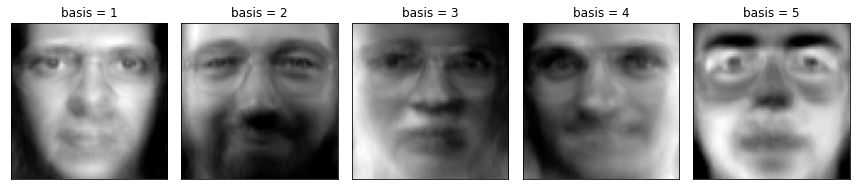

In [14]:
# MUR with Euclidean Distance

W = np.random.uniform(low = 0.0001, high = 1.0, size = (m, r))
H = np.random.uniform(low = 0.0001, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurEuclideanDistance(X, W, H)

plt.gray()
    
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for ax, i in zip(axs.flat, range(r)):
    ax.imshow(W.T[i].reshape(64, 64))
    ax.set_title('basis = {}'.format(i+1))
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

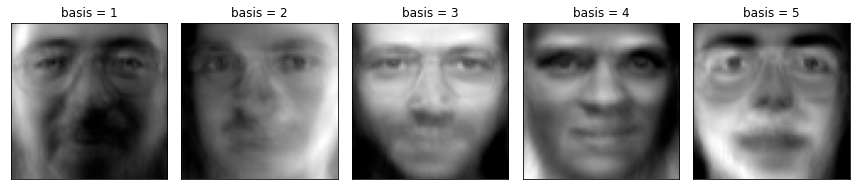

In [15]:
# MUR with I-divergence

W = np.random.uniform(low = 0.0001, high = 1.0, size = (m, r))
H = np.random.uniform(low = 0.0001, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurIDivergence(X, W, H)

plt.gray()
    
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for ax, i in zip(axs.flat, range(r)):
    ax.imshow(W.T[i].reshape(64, 64))
    ax.set_title('basis = {}'.format(i+1))
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

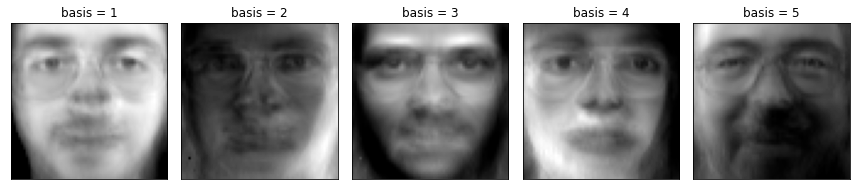

In [16]:
# MUR with Dual I-divergence

W = np.random.uniform(low = 0.0001, high = 1.0, size = (m, r))
H = np.random.uniform(low = 0.0001, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurDIDivergence(X, W, H)

plt.gray()
    
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for ax, i in zip(axs.flat, range(r)):
    ax.imshow(W.T[i].reshape(64, 64))
    ax.set_title('basis = {}'.format(i+1))
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

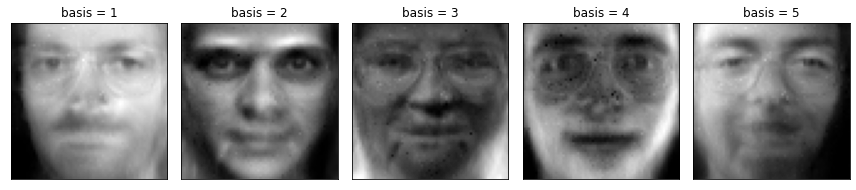

In [17]:
# MUR with Itakura-Saito divergence

W = np.random.uniform(low = 0.0001, high = 1.0, size = (m, r))
H = np.random.uniform(low = 0.0001, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurItakuraSaitoDivergence(X, W, H)

plt.gray()    

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for ax, i in zip(axs.flat, range(r)):
    ax.imshow(W.T[i].reshape(64, 64))
    ax.set_title('basis = {}'.format(i+1))
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

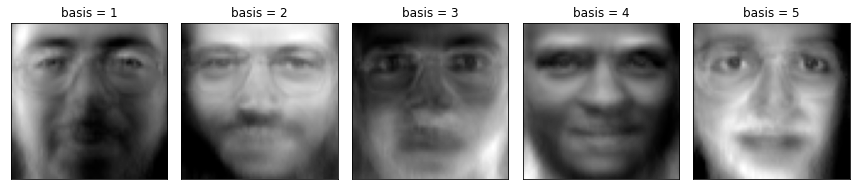

In [18]:
# MUR with Alpha-distance

alpha = 2.0 # hyperparameter

W = np.random.uniform(low = 0.0001, high = 1.0, size = (m, r))
H = np.random.uniform(low = 0.0001, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurAlphaDivergence(X, W, H, alpha)

plt.gray()
    
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for ax, i in zip(axs.flat, range(r)):
    ax.imshow(W.T[i].reshape(64, 64))
    ax.set_title('basis = {}'.format(i+1))
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

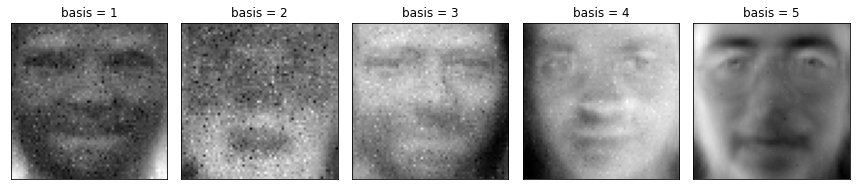

In [19]:
# MUR with Beta-divergence

beta = 2.0 # hyperparameter

W = np.random.uniform(low = 0.0001, high = 1.0, size = (m, r))
H = np.random.uniform(low = 0.0001, high = 1.0, size = (r, n))

for i in range(max_iter):
    W, H = MurBetaDivergence(X, W, H, beta)

plt.gray()
    
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left = 0.1, right = 0.9, wspace= 1.0)

for ax, i in zip(axs.flat, range(r)):
    ax.imshow(W.T[i].reshape(64, 64))
    ax.set_title('basis = {}'.format(i+1))
    
plt.tight_layout()
plt.show()